# Маркетинговая аналитика развлекательного приложения

Развлекательное приложение на протяжение нескольких месяцев несет убытки, не смотря на то, что в рекламу вложена куча денег. В распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Необходимо разобраться в ситуации.


# Цели
- Изучить, как люди начинают покупать
- Определить, какие факторы отрицательно влияют на привлечение пользователей
- Дать рекомендации для отдела маркетинга по повышению эффективности

# Описание данных
Предоставлено три датасета. Файл visits_info.csv хранит лог сервера с информацией о посещениях сайта, orders_info.csv — информацию о покупках, а costs.csv — информацию о расходах на рекламу.

Структура visits_info.csv
- User Id — уникальный идентификатор пользователя,
- Region — страна пользователя,
- Device — тип устройства пользователя,
- Channel — идентификатор источника перехода,
- Session Start — дата и время начала сессии,
- Session End — дата и время окончания сессии.

Структура orders_info.csv
- User Id — уникальный идентификатор пользователя,
- Event Dt — дата и время покупки,
- Revenue — сумма заказа.

Структура costs_info.csv
- Channel — идентификатор рекламного источника,
- Dt — дата проведения рекламной кампании,
- Costs — расходы на эту кампанию.

# 1. Загрузка данные и подготовка их к анализу

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter('ignore')

try:
    visits, orders, costs = (
        pd.read_csv('E:/Python/Project 5/visits_info.csv'),  
        pd.read_csv('E:/Python/Project 5/orders_info.csv'),  
        pd.read_csv('E:/Python/Project 5/costs_info.csv'),  
    )
except:
    visits, orders, costs = (
        pd.read_csv('/datasets/visits_info.csv'),  
        pd.read_csv('/datasets/orders_info.csv'),  
        pd.read_csv('/datasets/costs_info.csv'),  
    )

In [2]:
visits.info()
visits.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,01.05.2019 02:36,01.05.2019 02:45
1,278965908054,United States,iPhone,organic,01.05.2019 04:46,01.05.2019 04:47


In [3]:
orders.info()
orders.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99


In [4]:
costs.info()
costs.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1


In [5]:
visits.duplicated().sum(), orders.duplicated().sum(), costs.duplicated().sum()

(0, 0, 0)

In [6]:
# Приведем название всех колонок к нижнему регистру и заменим пробелы 
visits.columns = visits.columns.str.lower()
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns.values]
orders.columns = orders.columns.str.lower()
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns.values]
costs.columns = costs.columns.str.lower()

# Приведем колонки с датой к типу datetime для удобства работы
visits['session_start'] = pd.to_datetime(visits['session_start'], format='%d.%m.%Y %H:%M')
visits['session_end'] = pd.to_datetime(visits['session_end'], format='%d.%m.%Y %H:%M')
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 


ВЫВОД: 


Данные о визитах, заказах и расходах отимизированы, проверены на наличие дубликатов и готовы к дальнейшему анализу.

# 2. Исследовательский анализ данных

###  2.1 Создание пользовательских профилей и определение крайних дат. 

In [7]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
  
    return profiles

In [8]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:00,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:00,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:00,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:00,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:00,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [9]:
# Определяем минимальную и максимальную дату привлечения пользователей
min_dt= profiles['dt'].min() 
max_dt= profiles['dt'].max()
min_dt, max_dt

(datetime.date(2019, 5, 1), datetime.date(2019, 10, 27))

- 01.05.2019 - Минимальная дата привлечения пользователей
- 10.12.2019 - Максимальная дата привлечения пользователей

### 2.2 Из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей?

In [10]:
# Напишем функцию для фильтрации данных
def filter_dat(profiles, col):
    data = profiles.pivot_table(
        index=col, values= ['user_id', 'payer'], aggfunc=({'user_id':'count','payer':'sum'}) 
    )
    data ['ratio_pay']=data['payer']/data['user_id']
    data=(
        data.rename(columns={'user_id': 'count_user'})
        .drop(['payer'], axis=1)
        .sort_values(by='ratio_pay', ascending=False)
    )
    return data
# Применем функцию для регионов
region_data = filter_dat(profiles, 'region')
region_data

,count_user,ratio_pay
region,,
United States,100002,0.069019
Germany,14981,0.041119
UK,17575,0.039829
France,17450,0.037994


###  2.3 Какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи?

In [11]:
# Применем функцию для устройств
device_data = filter_dat(profiles, 'device')
device_data

,count_user,ratio_pay
device,,
Mac,30042,0.063644
iPhone,54479,0.062079
Android,35032,0.058518
PC,30455,0.050468


### 2.4  Изучение рекламныех источников привлечения.

In [12]:
# Применем функцию для каналов
channel_data = filter_dat(profiles, 'channel')
channel_data

,count_user,ratio_pay
channel,,
FaceBoom,29144,0.122049
AdNonSense,3880,0.113402
lambdaMediaAds,2149,0.104700
TipTop,19561,0.096007
RocketSuperAds,4448,0.079137
WahooNetBanner,8553,0.052964
YRabbit,4312,0.038265
MediaTornado,4364,0.035747
LeapBob,8553,0.030633


### ВЫВОД:
- United States приносит больше всех стран платящих пользователей, европа менее активна.
- Стоит обратить внимание на долю платящих с PC, т.к. она более чем на 20% ниже, чем Mac при практически одинаковом количестве пользователей.
- Очень существенно отличаются доли платящих по каналам, нужно изучить по подробнее и возможно перераспределить бюджеты.

# 3. Рассчет метрик
Продукт:

-    Сколько людей пользуются в день, неделю, месяц?
-    Сколько сессий в день?
-    Сколько длится одна сессия?

Продажи:

- Когда люди начинают покупать?
- Сколько покупок делает в среднем платящий пользователь за месяц, неделю, день?
- Какой средний чек за месяц, неделю, день?

Маркетинг:

- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

### 3.1 Продукт:
####  3.1.1 Метрики  DAU, WAU и MAU. 

In [13]:
# выделяем год, номер месяца и номер недели из времени начала сессии
visits['session_year'] = visits['session_start'].dt.year
visits['session_month'] = visits['session_start'].dt.month
visits['session_week'] = visits['session_start'].dt.week
visits['session_date'] = visits['session_start'].dt.date



dau_total = (
    visits.groupby('session_date').agg({'user_id': 'nunique'})
)

wau_total = (
    visits.groupby(['session_year', 'session_week'])
    .agg({'user_id': 'nunique'})
)

mau_total = (
    visits.groupby(['session_year', 'session_month'])
    .agg({'user_id': 'nunique'})
)

int(dau_total.mean()), int(wau_total.mean()), int(mau_total.mean())

(1684, 8353, 28989)

- Среднее DAU:  1684
- Среднее WAU:  8353
- Среднее MAU: 28989 

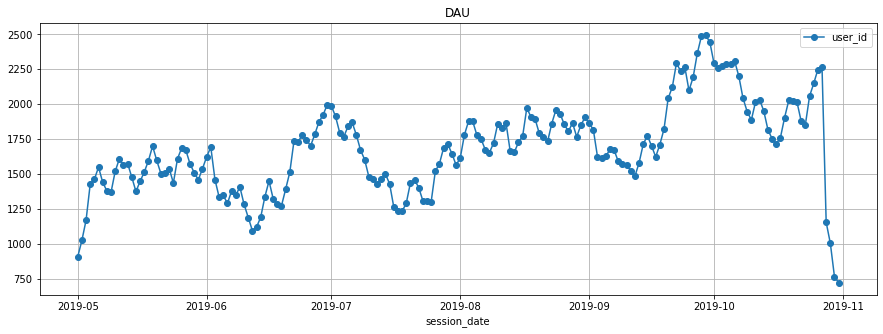

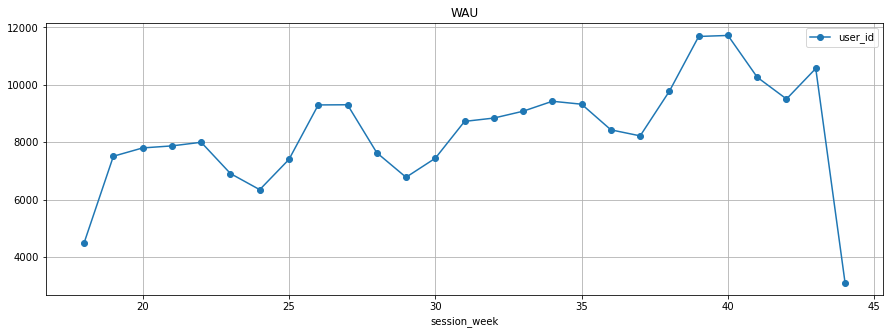

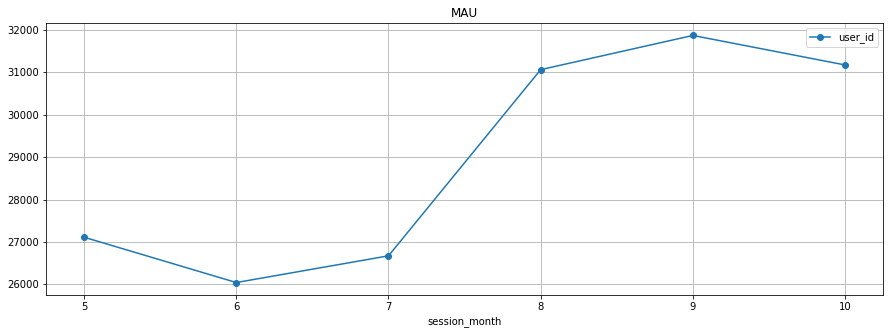

In [14]:

def plot_au (total, title, dat):
    total.reset_index().plot(
            x = 'session_{}'.format(dat),
            y = 'user_id',
            style = 'o-',
            figsize = (15,5),
            grid = True,
            title = title
        )
plot_au(dau_total, 'DAU', 'date')
plot_au(wau_total, 'WAU', 'week')
plot_au(mau_total, 'MAU', 'month')

plt.show()

На данных графиках просматривается общий тренд роста интереса к приложению. Примечательными являются просадки и пики в течении месяца, разница между которыми иногда в 2 раза. Возможно, маркетологи упускают окончания контрактов с каналами привлечения пользователей.

#### 3.1.2 Изучение пользовательских сессий. 

user_id    1684.244565
dtype: float64

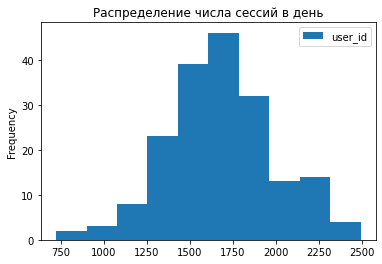

In [15]:
scd = (
    visits.groupby('session_date').agg({'user_id': 'count'})
)

scd.plot(
    kind = 'hist',
    y = 'user_id',
    title = 'Распределение числа сессий в день'
)
scd.mean()

#### 3.1.3 Сколько длится одна сессия?

<AxesSubplot:>

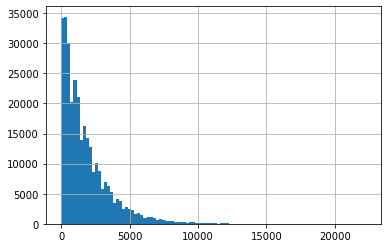

In [16]:
visits['session_lenght'] =(visits['session_end'] - visits['session_start']).dt.seconds
visits['session_lenght'].hist(bins=100)

In [17]:
descr=visits['session_lenght'].describe()
descr

count    309901.000000
mean       1800.084801
std        1803.189827
min           0.000000
25%         540.000000
50%        1260.000000
75%        2520.000000
max       22260.000000
Name: session_lenght, dtype: float64

In [18]:
data={'values':[descr['count'], descr['mean'], descr['std'], descr['min'], descr['max']]}
index=['count', 'mean', 'std', 'min', 'max']
desc=pd.DataFrame(data, index=index)
desc

,values
count,309901.000000
mean,1800.084801
std,1803.189827
min,0.000000
max,22260.000000


### 3.2 Продажи:

#### 3.2.1 Сколько времени в среднем проходит с момента первого посещения до покупки?

In [19]:
first_orders = orders.groupby('user_id').agg({'event_dt': 'min'})
first_orders = first_orders.merge(profiles [{'user_id','first_ts'}], on='user_id', how = 'left')
first_orders['first_order_sec']= (first_orders['event_dt'] - first_orders['first_ts']).dt.total_seconds()
first_orders['first_order_sec'].mean()
first_orders['first_order_sec'].describe()

count    8.881000e+03
mean     1.627107e+05
std      5.215402e+05
min      0.000000e+00
25%      4.100000e+01
50%      7.000000e+01
75%      1.277320e+05
max      1.141890e+07
Name: first_order_sec, dtype: float64

<AxesSubplot:>

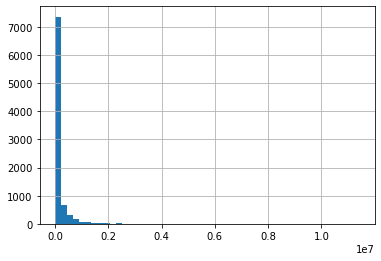

In [20]:
first_orders['first_order_sec'].hist(bins=50)

Из описания и гистограмы видно, что среднее и медиана сильно различаются. Логичнее исследовать медиану = 70.

Большая часть значений сконцентрирована до 1 минуты. Это повод проверить, нет ли технических ошибок. Стоит более глубоко исследовать этот момент.

#### 3.2.2 Среднее число покупок на одного покупателя за день, неделю и месяц. 

1.0000345022303812

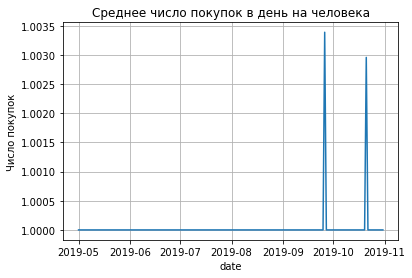

In [21]:
orders['date']= orders['event_dt'].dt.date
orders_date=orders.groupby('date').agg({'revenue': 'count', 'user_id': 'nunique'})

orders_date['av_orders'] = orders_date['revenue']/orders_date['user_id']
orders_date['av_orders'].plot(grid=True)
plt.ylabel('Число покупок')
plt.title('Среднее число покупок в день на человека')
orders_date['av_orders'].mean()

1.3266628820826014

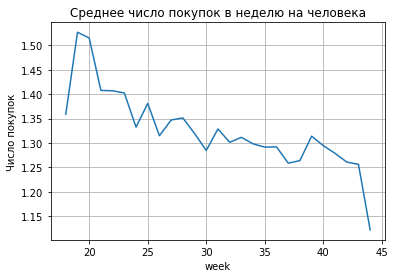

In [22]:
orders['week']= orders['event_dt'].dt.week
orders_week=orders.groupby('week').agg({'revenue': 'count', 'user_id': 'nunique'})

orders_week['av_orders'] = orders_week['revenue']/orders_week['user_id']
orders_week['av_orders'].plot(grid=True)
plt.ylabel('Число покупок')
plt.title('Среднее число покупок в неделю на человека')
orders_week['av_orders'].mean()

2.228447784645054

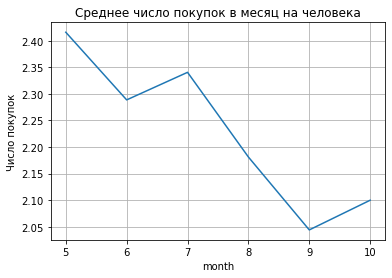

In [23]:
orders['month']= orders['event_dt'].dt.month
orders_month=orders.groupby('month').agg({'revenue': 'count', 'user_id': 'nunique'})

orders_month['av_orders'] = orders_month['revenue']/orders_month['user_id']

orders_month['av_orders'].plot(grid=True)
plt.ylabel('Число покупок')
plt.title('Среднее число покупок в месяц на человека')
orders_month['av_orders'].mean()

#### 3.2.3 Средний чек за день, неделю и месяц. 

Text(0.5, 1.0, 'Средний чек за день')

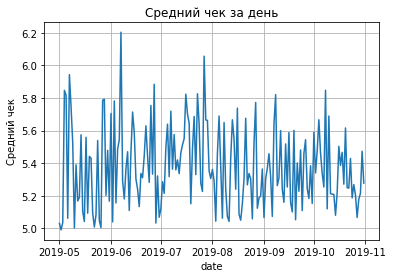

In [24]:
revenue_date=orders.groupby('date').agg({'revenue': 'sum', 'user_id': 'count'})

revenue_date['av_revenue'] = revenue_date['revenue']/revenue_date['user_id']
revenue_date['av_revenue'].plot(grid=True)
plt.ylabel('Средний чек')
plt.title('Средний чек за день')

Text(0.5, 1.0, 'Средний чек за неделю')

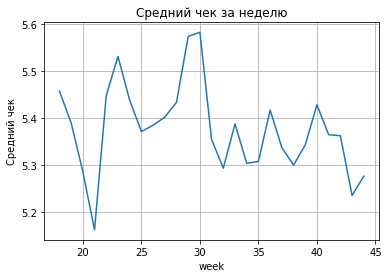

In [25]:
revenue_week=orders.groupby('week').agg({'revenue': 'sum', 'user_id': 'count'})

revenue_week['av_revenue'] = revenue_week['revenue']/revenue_week['user_id']
revenue_week['av_revenue'].plot(grid=True)
plt.ylabel('Средний чек')
plt.title('Средний чек за неделю')

Text(0.5, 1.0, 'Средний чек за месяц')

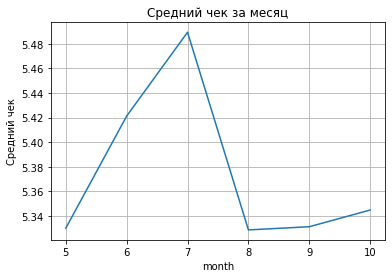

In [26]:
revenue_month=orders.groupby('month').agg({'revenue': 'sum', 'user_id': 'count'})

revenue_month['av_revenue'] = revenue_month['revenue']/revenue_month['user_id']
revenue_month['av_revenue'].plot(grid=True)
plt.ylabel('Средний чек')
plt.title('Средний чек за месяц')

По графику видно, что средний чек за месяц не имел высокой волатильности (не более 3% за исследуемый период). Если рассматривать среднее по дням, то волатильность достигала 25% за исследуемый период. Можно оценить и найти точки роста.

### 3.3 Маркетинг:

#### 3.3.1 Общая сумма расходов на маркетинг. 

In [27]:
#costs['date']= costs['event_dt'].dt.date
costs_channel=costs.groupby('channel').agg({'costs': 'sum'})
costs_channel

,costs
channel,
AdNonSense,3911.25
FaceBoom,32445.60
LeapBob,1797.60
MediaTornado,954.48
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
TipTop,54751.30
WahooNetBanner,5151.00
YRabbit,944.22


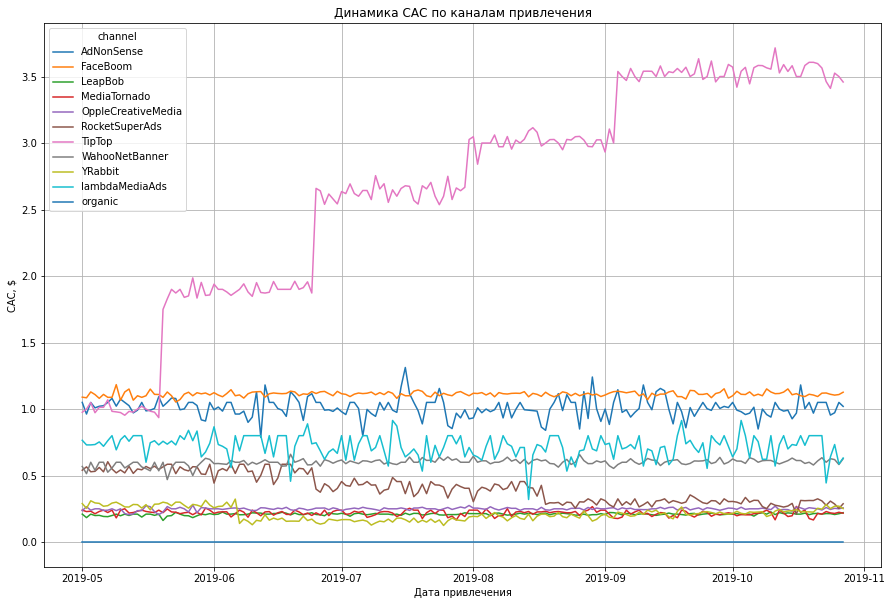

105497.30000000002

In [28]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(15, 10))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()
costs['costs'].sum()

#### 3.3.2 Сколько в среднем стоило привлечение одного пользователя из каждого источника?

In [29]:
profiles['acquisition_cost'].mean()


0.7032778251827625

In [30]:
profiles.pivot_table(
index='channel', values='acquisition_cost', aggfunc='mean'
).sort_values(by='acquisition_cost',ascending=False)

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


### ВЫВОД
 Продукт:
- Количество людей, пользующихся приложением, планомерно росло за весь период исследования
- Среднее число сессий в день: 1684
- В среднем одна сессия длится: 1800 сек.или 0.5 час. 

Продажи:
- Люди покупают после первого посещения в среднем через: 162710 сек. или около 2 дней , медиана 70 сек. Повод исследовать поподробнее
- Среднее число покупок в неделю и в месяц планомерно снижалось, на это стоит обратить внимание
- Средний чек за день колебался от 5 до 6.2, за неделю от 5.2 до 5.6, за месяц от 5.35 до 5.48

Маркетинг:
- Всего на маркетинг потратили: 105497. Примечателен рост расходов на канал TipTop.
- Стоимость привлечения из канала TipTop в несколько раз выше остальных, обратим внимание.

# 4. Оцените окупаемость рекламы для привлечения пользователей

## 4.1 Создание функций

In [31]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [32]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [33]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [34]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [35]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [36]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [37]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## 4.2 Проанализируем общую окупаемость рекламы. 

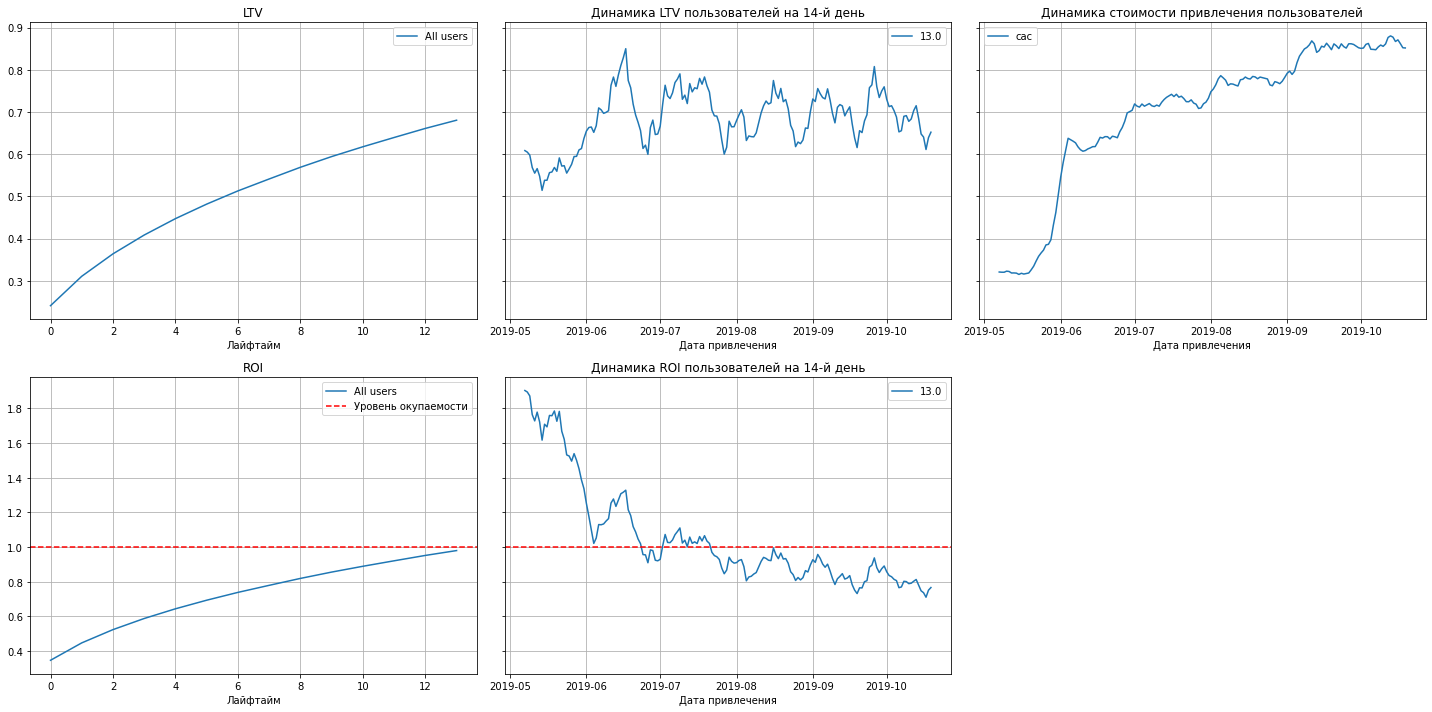

In [38]:
observation_date = datetime(2019, 11, 1).date()  
horizon_days = 14 

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)
    
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

## 4.3 Проанализируем окупаемость рекламы с разбивкой по рекламным каналам.

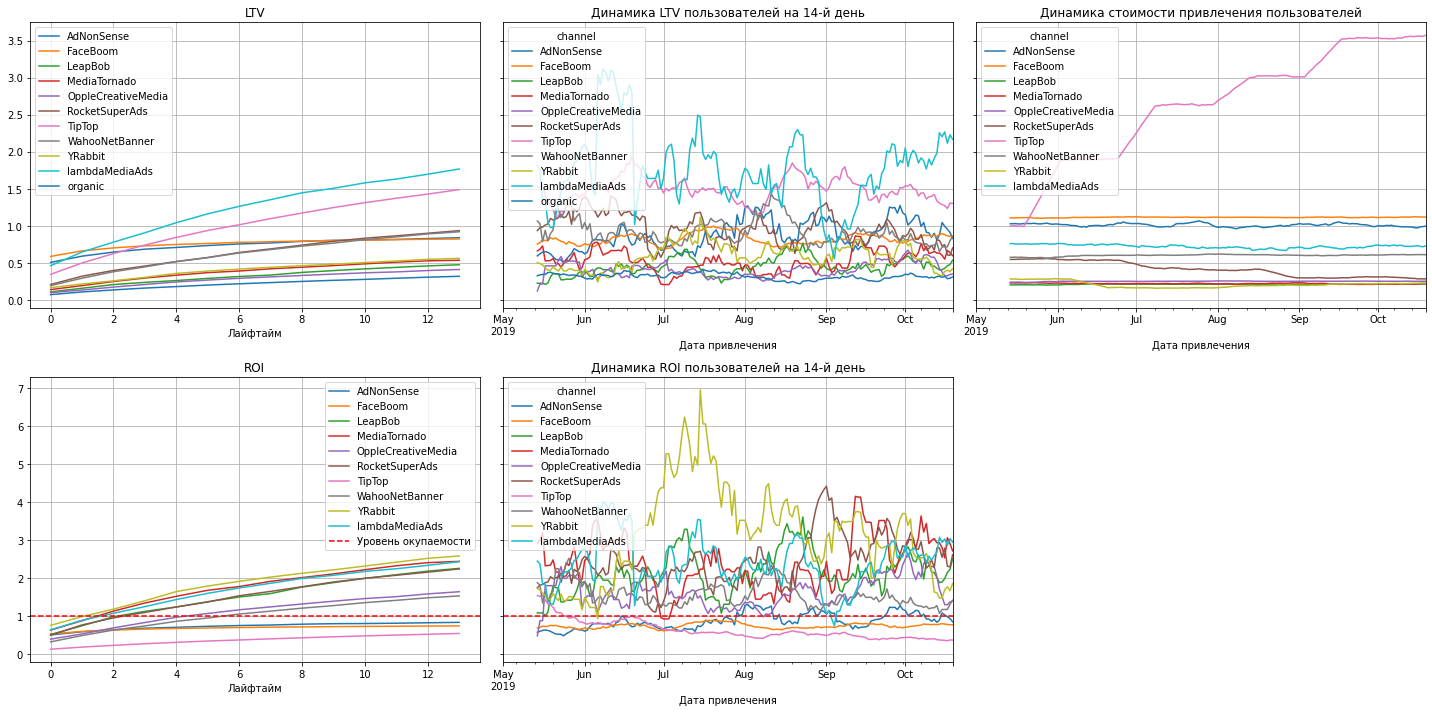

In [39]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 


## 4.4 Проанализируем окупаемость рекламы с разбивкой по странам.

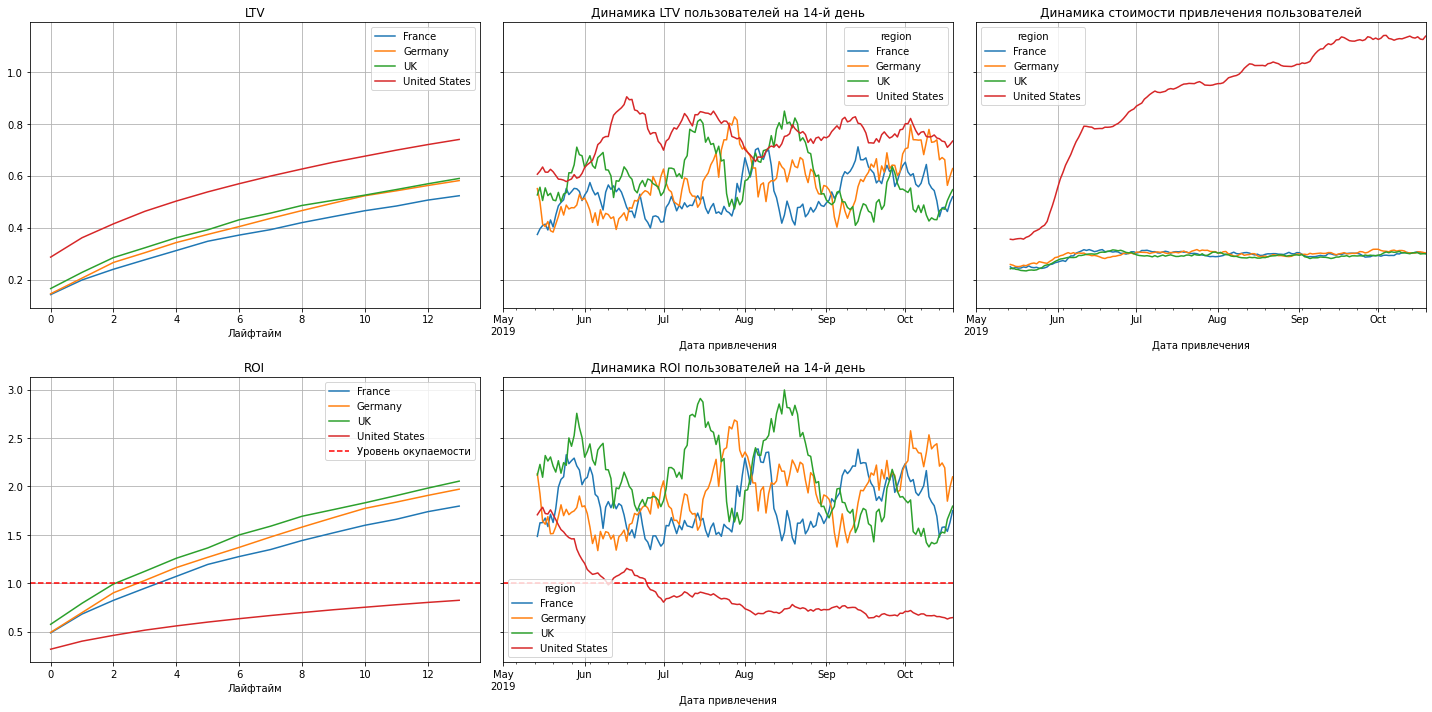

In [40]:
dimensions = ['region'] 

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

ВЫВОДЫ:

- Из первых графиков очевидно, что САС растет, а ROI падает. Бизнес-план не выполняется (ROI показывает, что нет окупаемости за 2 недели. 
- Как было замечено ранее, САС расчтет исключительно из-за одного канала TipTop и как ни странно, у этого канала самая низкая ROI. Маркетингу стоит изменить свою работу с этим каналом. Также выполнению бизнесплана не способствуют каналы: AdNonSense u FaceBoom
- Unaited States наиболее "больная" страна: САС стремительно растет, ROI падает. Если бы не они, окупаемость начиналась уже на 4-ый день. 

### 4.5 Изучение конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам.

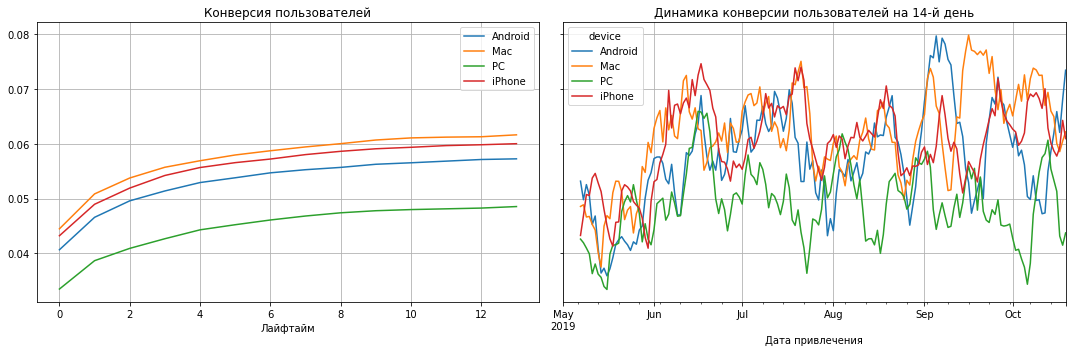

In [41]:
# смотрим конверсию с разбивкой по устройствам

dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

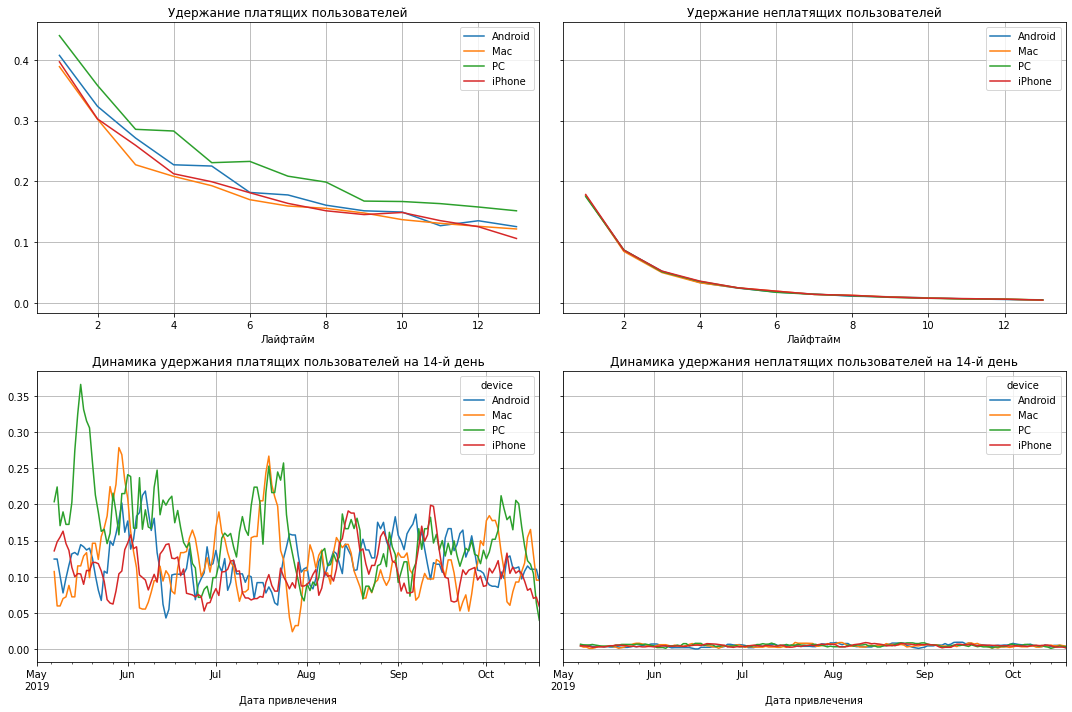

In [42]:
# смотрим удержание с разбивкой по устройствам


retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

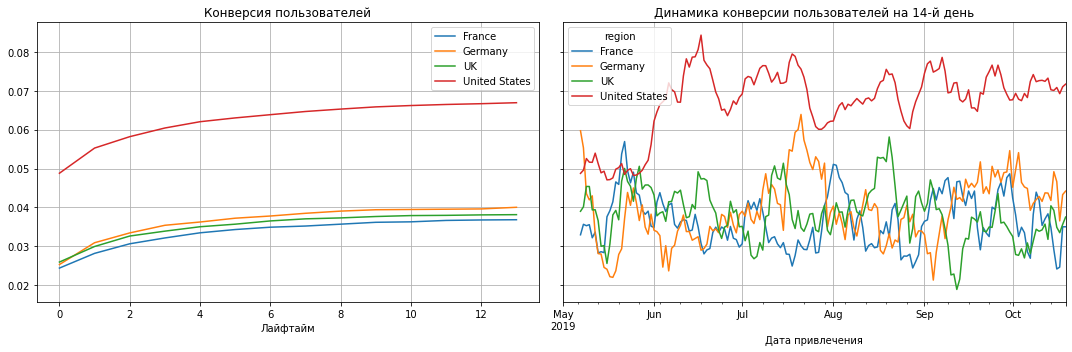

In [43]:
# смотрим конверсию с разбивкой по странам

dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

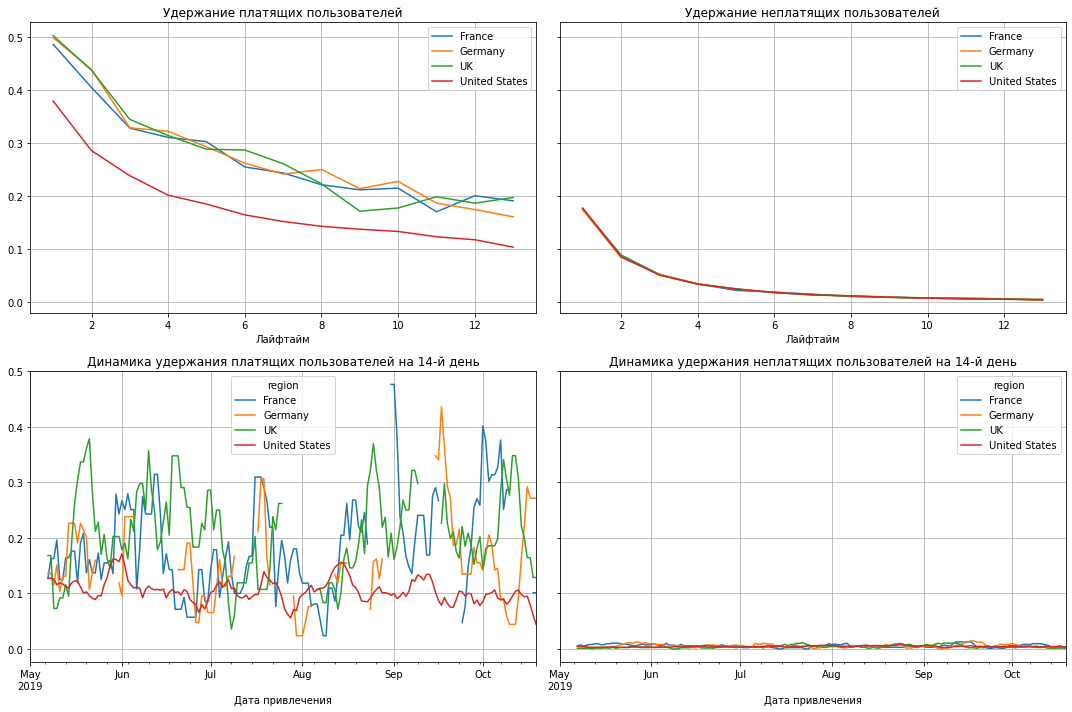

In [44]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

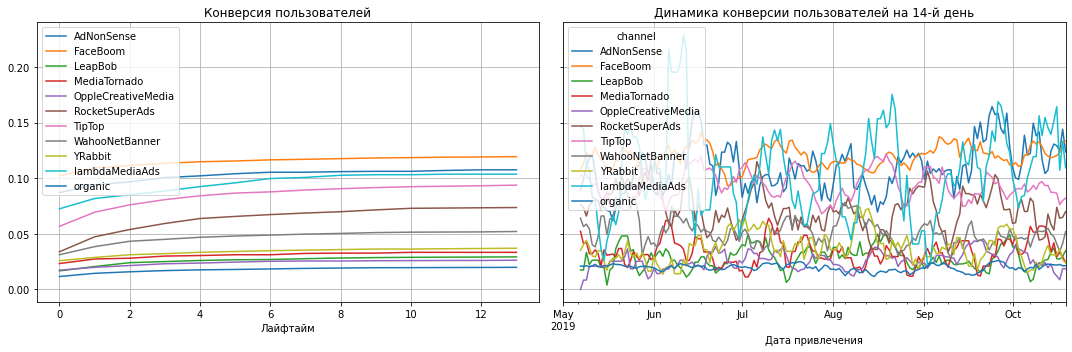

In [45]:
# смотрим конверсию с разбивкой по рекламным каналам

dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

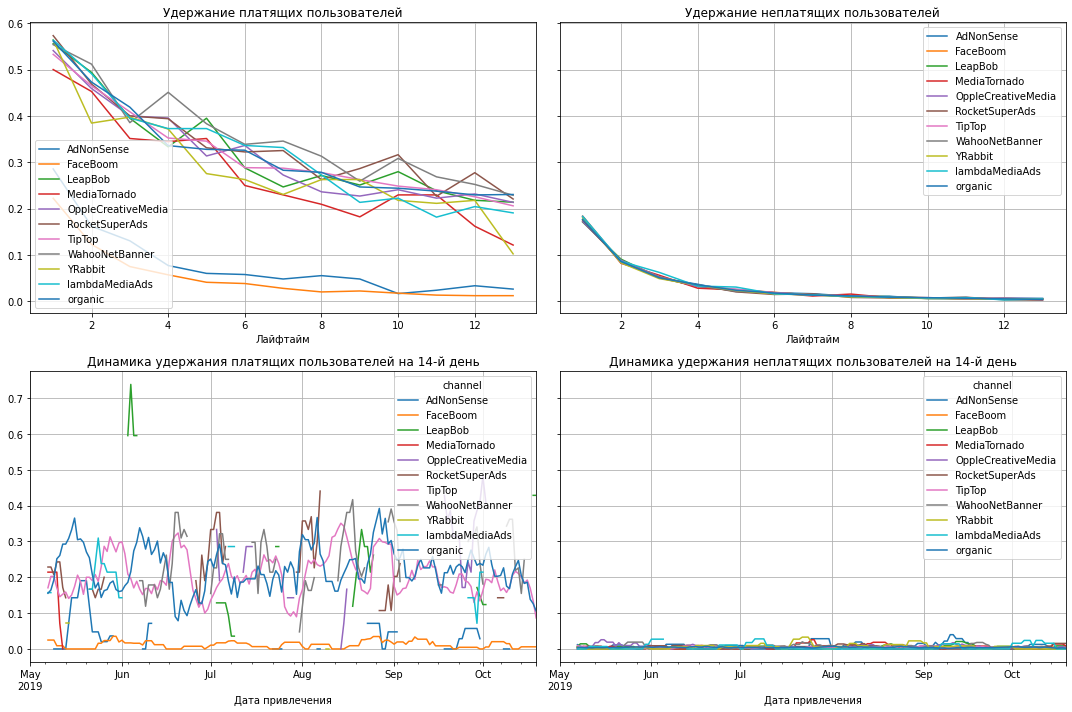

In [46]:
# смотрим удержание с разбивкой по рекламным каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

ВЫВОДЫ:
- По устройствам явных проблем для радости и беспокойства нет. Стоит обратить внимание на пользователей РС, как я говорил ранее.
- По странам Unaited States вызывает сильное беспокойство по нискому удержанию с высокой конверсией. Сделаем заключение дальше.
- По каналам лидеры по конверсии и ониже аутсайдеры по удержанию AdNonSense u FaceBoom. При этом с положительной стороны отмечу lambdaMediaABS за высокую конверсию и хорошее удержание.  

### Ответы на  вопросы:
`Окупается ли реклама в целом?`
- В целом реклама не окупается за 14 дней.

`Какие устройства, страны и каналы могут снижать окупаемость рекламы?`
- Устройства РС снижают окупаемость. Доля платящих среди них на 20% ниже, чем на остальных устройтвах. Возможно, проблемы с процедурой оплаты для этих устройств.

`Чем могут быть вызваны проблемы окупаемости?`
- В Unaited States высокая конверсия, но низкое удержание и окупаемость. Возможно дело в среднем чеке либо в завышеной цене привлечения. Необходим доп анализ сопоставления с каналами по этой стране и сравнение ср чеков с остальными странами.
- TipTop необоснованно поднимает цены на привлечение. AdNonSense u FaceBoom имеют высокую конверсию, но низкое удержание и LTV, что негативно влияет на окупаемость. Видимо отдел маркетинга выбирал их основывась только на высокую конверсию, но в прибыль она не переходит.


### Дополнительно исследуем рынок США:

In [47]:
profiles_US=profiles[profiles['region'] == 'United States']
profiles_US

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:00,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:00,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
4,31989216,2019-10-02 00:07:00,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
5,34186288,2019-05-09 17:29:00,organic,Android,United States,2019-05-09,2019-05-01,False,0.000000
6,38448301,2019-08-16 11:56:00,organic,Android,United States,2019-08-16,2019-08-01,False,0.000000
...,...,...,...,...,...,...,...,...,...
150001,999949280903,2019-08-12 06:47:00,FaceBoom,Mac,United States,2019-08-12,2019-08-01,False,1.117838
150003,999956196527,2019-09-28 08:33:00,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150005,999976332130,2019-07-23 02:57:00,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:00,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


In [48]:
# Какими устройствами чаще пользуются в США
device_data_US = filter_dat(profiles_US, 'device')
device_data_US

,count_user,ratio_pay
device,,
Android,20199,0.073618
Mac,24842,0.068674
PC,10432,0.068539
iPhone,44529,0.067237


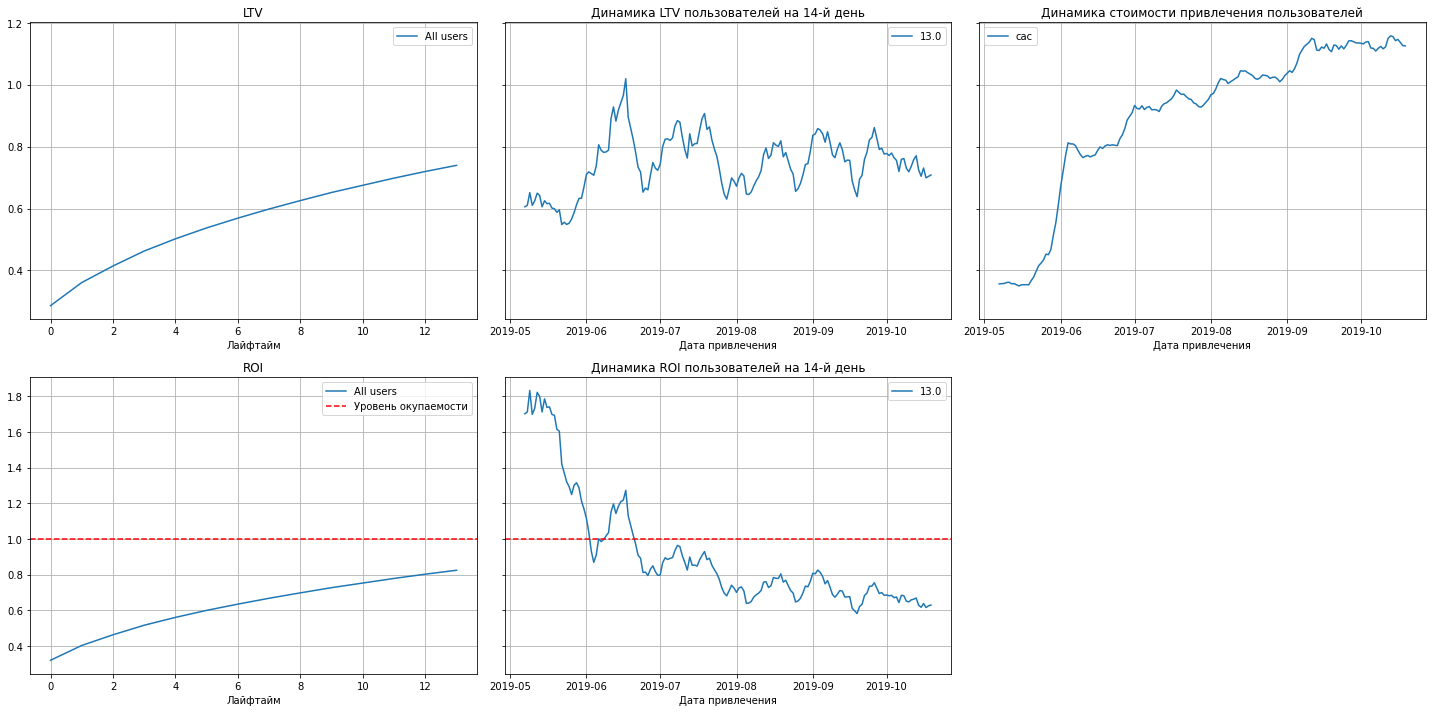

In [49]:
# Оценим общую окупаемость рекламы по США
observation_date = datetime(2019, 11, 1).date()  
horizon_days = 14 

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_US, orders, observation_date, horizon_days
)
    
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

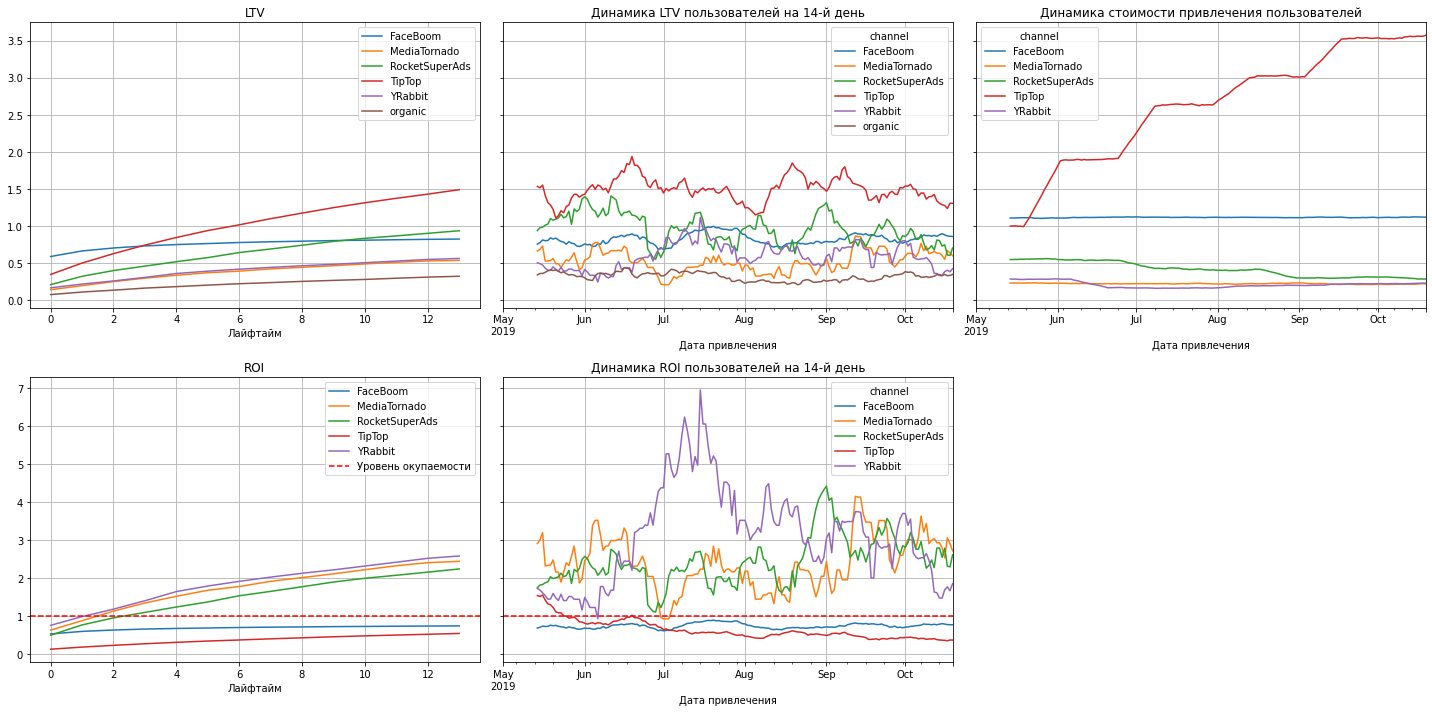

In [50]:
# Оценим окупаемость рекламы с разбивкой по каналам по США
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
     profiles_US, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 


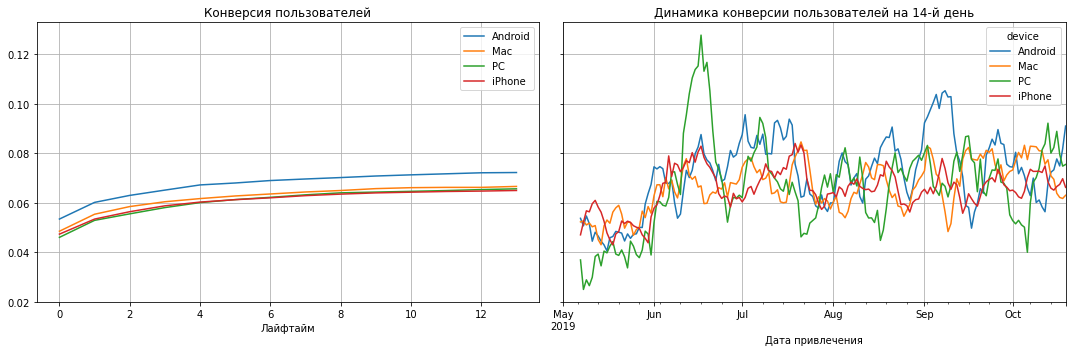

In [51]:
# Оценим конверсию с разбивкой по устройствам по США
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_US, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

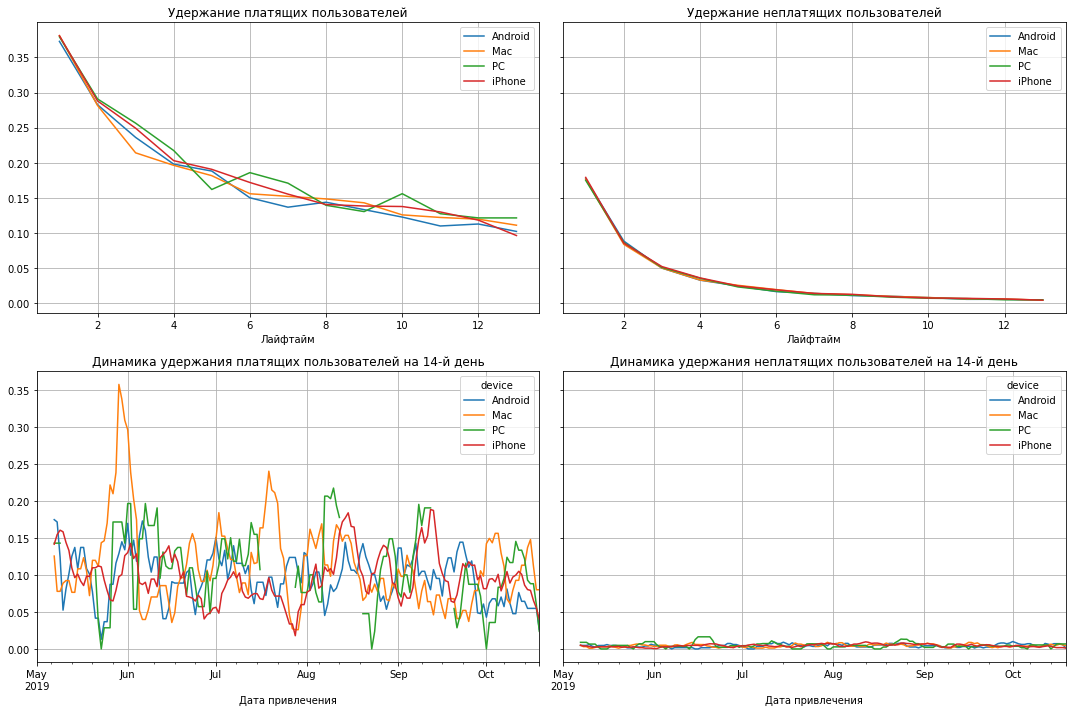

In [52]:
# смотрим удержание с разбивкой по устройствам


retention_raw, retention_grouped, retention_history = get_retention(
    profiles_US, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

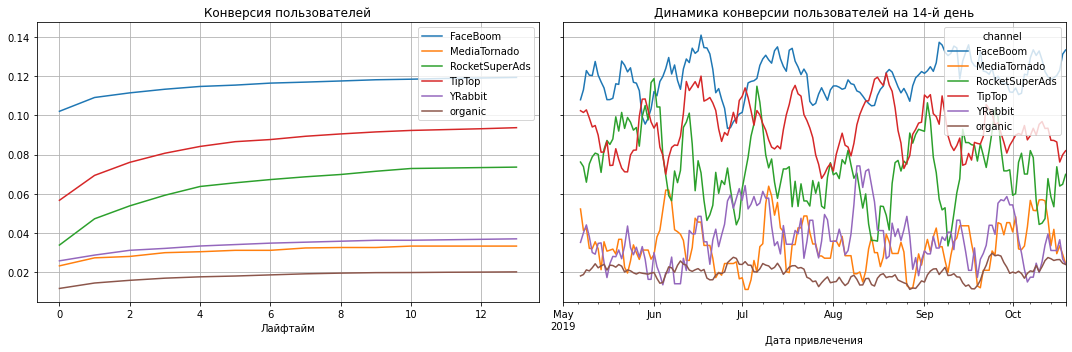

In [53]:
# смотрим конверсию с разбивкой по рекламным каналам

dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_US, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

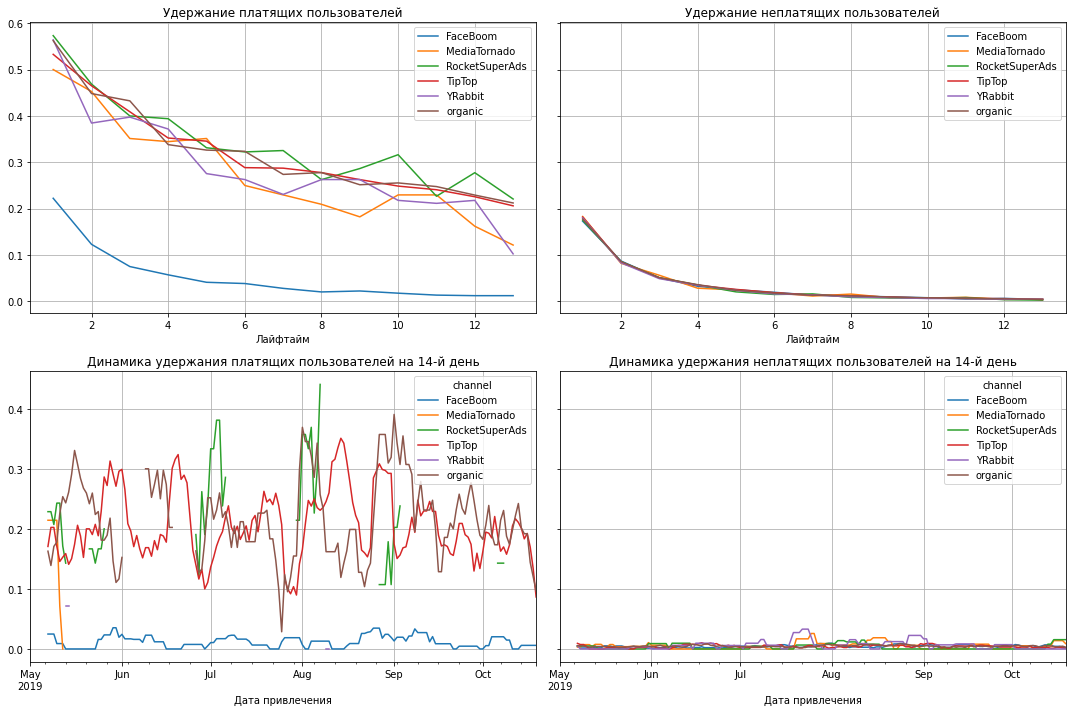

In [54]:
# смотрим удержание с разбивкой по рекламным каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_US, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Предварительные выводы подтвердились:
- Необходимо отказываться от инвестирования в TipTop u FaceBoom. Освободившийся бюджет вложить в MediaTornado и RocketSuperAds.
- США не влияет на сниженные показатели по доле платящих по РС.

# Общие выводы и рекомендации

Причины неэффективности привлечения пользователей:
- Необоснованно высокая цена привлечения в канале TipTop.
- Каналы AdNonSense u FaceBoom имеют высокую цену и конверсию, но с них возвращается мало денег, стоит проверить, на сколько они целевые.
- Разобраться в причинах низкой доли платящих в Европе. Возможно, есть проблемы с платежными системами. Необходимо отследить движение по воронке.

Рекомендации для отдела маркетинга для повышения эффективности:
- Отказаться от покупки пользователей через каналы TipTop, AdNonSense u FaceBoom.
- Вложить освободившийся бюджет в lambdaMediaABS и MediaTornado